In [1]:
import numpy as np
from scipy.optimize import root_scalar,fsolve
from scipy.integrate import quad

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

In [2]:
# Problem 1: RNGs

In [3]:
rng = np.random.default_rng(seed=12345)

N = 100000
sample = np.array([rng.random() for i in range(N)])

one sequence uniformity

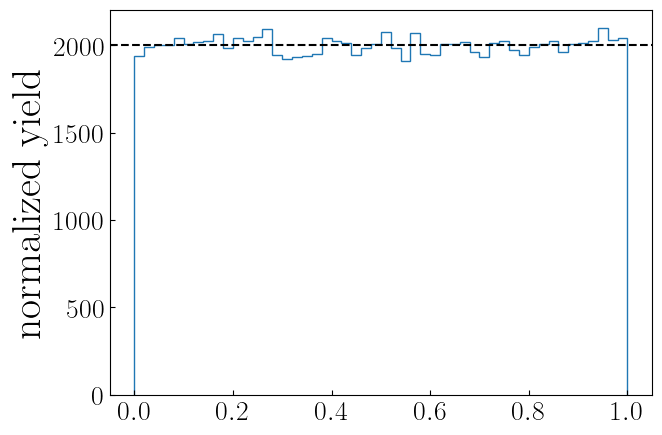

In [4]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

bins = 50
counts,edges = np.histogram(sample,bins=bins,density=False)
ax.stairs(counts,edges)

# ax.set_xlabel(r'$\rm bin$',size=30)
ax.set_ylabel(r'$\rm normalized~yield$',size=30)
ax.tick_params(which='major',axis='both',labelsize=20,direction='in')
ax.axhline(N/bins,color='k',ls='--')


plt.show()

parking lot

In [5]:
N = 1000
sample1 = np.array([rng.random() for i in range(N)])
sample2 = np.array([rng.random() for i in range(N)])

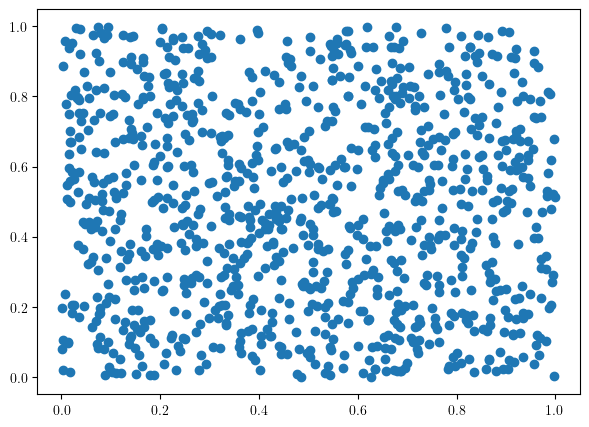

In [6]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.scatter(sample1,sample2)

plt.show()

moments and correlation

In [7]:
def get_mom(sample,n=1):
    return np.sum(sample**n)/sample.shape[0]

def get_nn_corr(sample,k=1):
    return np.sum(sample[:-k]*sample[k:])/sample.shape[0]

In [8]:
N = np.arange(10,10000,100)

n = 5
k = 5
mom  = []
corr = []
for _ in N:
    temp = np.array([rng.random() for i in range(_)])
    mom.append(get_mom(temp,n=n))
    corr.append(get_nn_corr(temp,k=k))

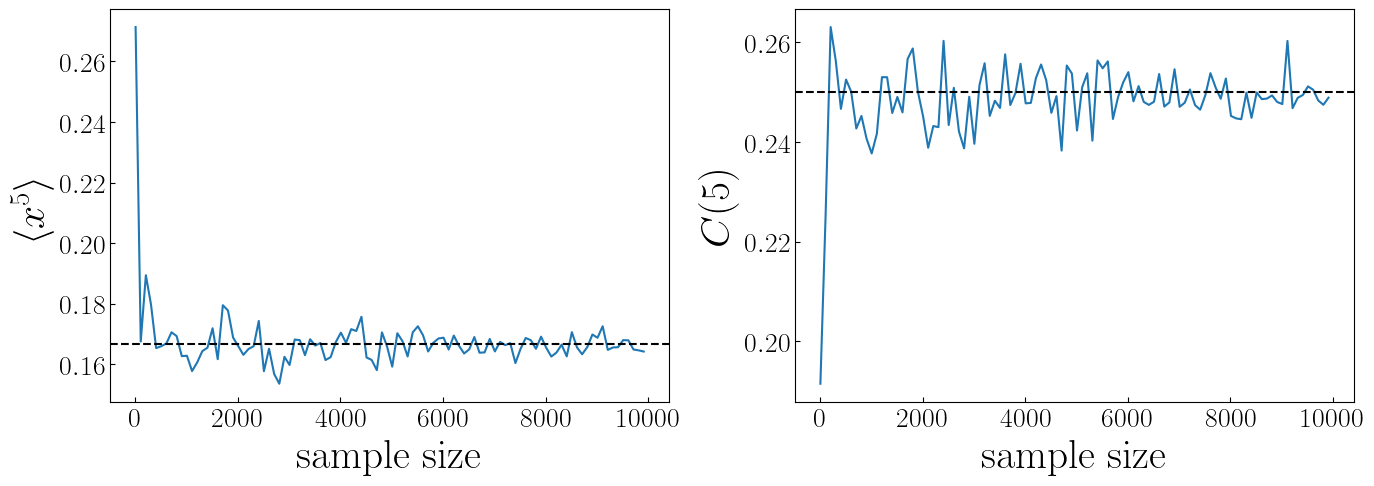

In [9]:
nrows,ncols=1,2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax[0].plot(N,mom)
ax[0].axhline(1/(k+1),color='k',ls='--')

ax[1].plot(N,corr)
ax[1].axhline(1/4,color='k',ls='--')

for i in range(2):
    ax[i].set_xlabel(r'$\rm sample~size$',size=30)
    ax[i].tick_params(axis='both',which='major',direction='in',labelsize=20)
ax[0].set_ylabel(r'$\langle x^{%d} \rangle$'%n,size=30)
ax[1].set_ylabel(r'$C(%d)$'%k,size=30)

fig.tight_layout()
plt.show()

# Problem 2: non-uniform sampling

In [10]:
def transform_sample(N,F_inv=None,F=None,f=None):
    '''
        generate N samples from desired probability density
        -- ordering of optional parameters by priority/preference
           i.e. if F_inv (func) known analytically pass to this (best method)
                else if F known analytically pass to this (not too bad in most cases)
                else if only PDF known pass to f (not very good in general)
    '''
    u = np.random.uniform(size=N)
    print(u)
    if F_inv is not None:
        sample = F_inv(u)
        print(sample)
    elif F is not None:
        temp = lambda t: F(t) - u
        sample = fsolve(temp,np.random.uniform(size=u.shape[0]))
    elif f is not None:
        F_   = lambda t: np.array([quad(f,-np.inf,_)[0] for _ in t])
        temp = lambda t: F_(t) - u
        sample = fsolve(temp,np.random.uniform(size=u.shape[0]))
        
    return sample

In [11]:
def rejection_sample(N,f,x_ext,y_ext,verb=0):
    x  = np.random.uniform(*x_ext,size=N)
    y  = np.random.uniform(*y_ext,size=N)
    f_ = f(x)
    diff = f_ - y
    sample = x[diff>=0]
    if verb:
        print(f'rejection rate: {1 - sample.shape[0]/N}')
    return sample

In [12]:
def metropolis_sample(N,f,x0=0,delta=1,bounds=[-np.inf,np.inf],verb=0):
    sample = [x0]
    f_     = [f(x0)]
    
    count = 0
    while len(sample) <= N:
        x1 = sample[-1] + delta*(2*np.random.uniform() - 1)
        
        if x1 < bounds[0] or x1 > bounds[1]:
            continue
            
        f1 = f(x1)
        r  = f1/f_[-1]
        u  = np.random.uniform()
        if u <= r:
            sample.append(x1)
            f_.append(f1)
        
        count += 1
    
    sample = np.array(sample)
    if verb:
        print(f'rejection rate: {(count - sample.shape[0])/N}')
    
    return sample

In [13]:
sample_dict = {}
N = 100000


func_a = lambda t: np.exp(-t)*(t > 0)
sample_dict['Poisson'] = {}
sample_dict['Poisson']['transform'] = transform_sample(N,F_inv=lambda t: -np.log(1-t))
sample_dict['Poisson']['rejection'] = rejection_sample(N,func_a,[0,10],[0,1],verb=1)
sample_dict['Poisson']['metropolis'] = metropolis_sample(N,func_a,x0=1,delta=0.1,verb=1)

print()

func_b = lambda t: 1/(np.pi*(1+t**2))
sample_dict['Cauchy'] = {}
sample_dict['Cauchy']['transform'] = transform_sample(N,F_inv=lambda t: np.tan(np.pi*(t-0.5)))
sample_dict['Cauchy']['rejection'] = rejection_sample(N,func_b,[-10,10],[0,1/np.pi],verb=1)
sample_dict['Cauchy']['metropolis'] = metropolis_sample(N,func_b,x0=0,delta=1,verb=1)

print()

func_c = lambda t: np.exp(-t**2/2)/np.sqrt(2*np.pi)
sample_dict['Gauss'] = {}
# sample_dict['Gauss']['transform'] = transform_sample(N,F_inv=lambda t: np.tan(np.pi*(t-1)/2))
sample_dict['Gauss']['rejection'] = rejection_sample(N,func_c,[-10,10],[0,1/np.sqrt(2*np.pi)],verb=1)
sample_dict['Gauss']['metropolis'] = metropolis_sample(N,func_c,x0=0,delta=1,verb=1)

[0.6664679  0.35540978 0.36417518 ... 0.1292949  0.41648178 0.00162252]
[1.09801617 0.43914048 0.4528322  ... 0.13845193 0.5386796  0.00162384]
rejection rate: 0.89783
rejection rate: 0.04798

[0.66986116 0.93963828 0.82799307 ... 0.00780578 0.50555335 0.55539457]
[ 5.90809777e-01  5.21001047e+00  1.66683211e+00 ... -4.07705886e+01
  1.74481195e-02  1.75805556e-01]
rejection rate: 0.85233
rejection rate: 0.18067

rejection rate: 0.87552
rejection rate: 0.24164


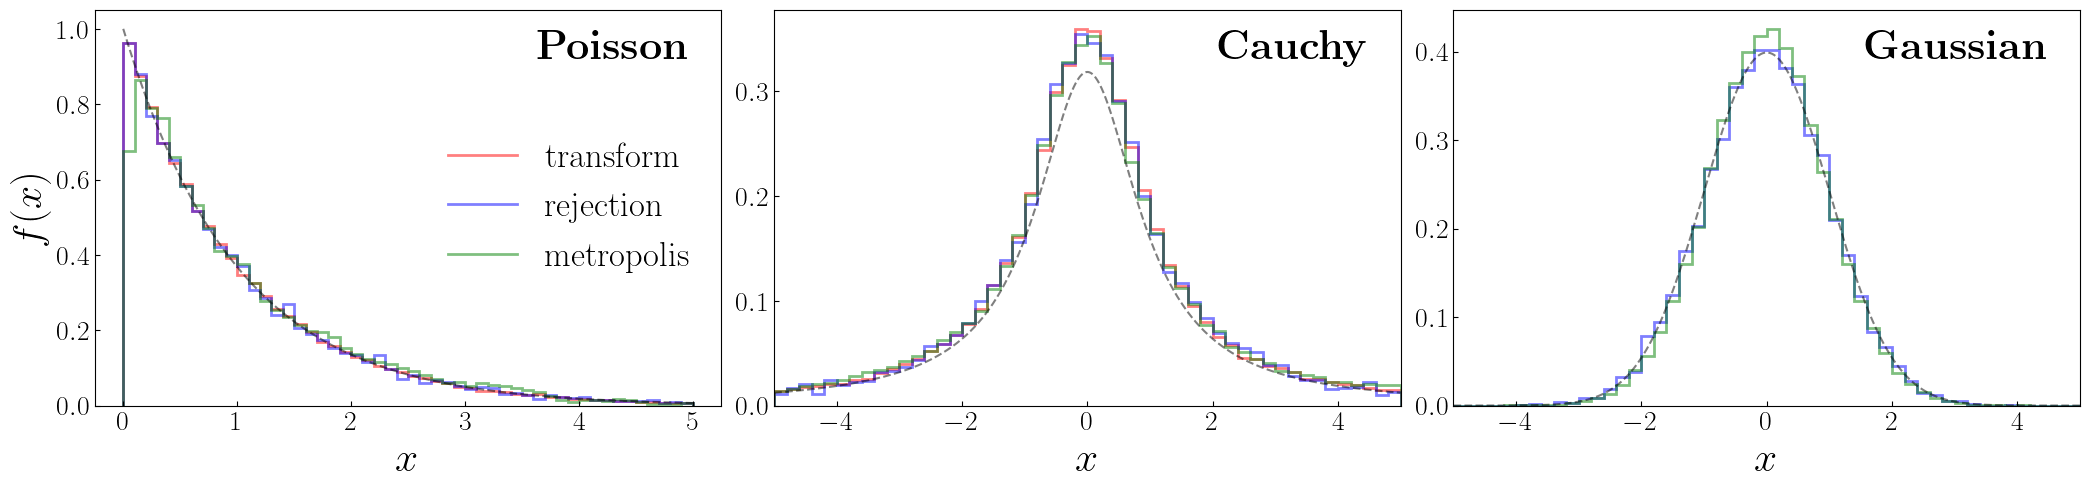

In [15]:
nrows,ncols = 1,3
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))


Range = {'Poisson': (0,5), 'Cauchy': (-5,5), 'Gauss': (-5,5)}
colors = {'transform':'r','rejection':'b','metropolis':'g'}
for i,dist in enumerate(sample_dict):
    for j,method in enumerate(sample_dict[dist]):
        sample = sample_dict[dist][method]
        counts,edges = np.histogram(sample,bins=50,range=Range[dist],density=True)
        ax[i].stairs(counts,edges,color=colors[method],lw=2,alpha=0.5,label=r'$\rm %s$'%method)

x = np.linspace(1e-15,5,1000)
ax[0].plot(x,func_a(x),'k--',alpha=0.5)

x = np.linspace(-5,5,1000)
ax[1].plot(x,func_b(x),'k--',alpha=0.5)
ax[1].set_xlim(-5,5)

x = np.linspace(-5,5,1000)
ax[2].plot(x,func_c(x),'k--',alpha=0.5)
ax[2].set_xlim(-5,5)


ax[0].text(s=r'\boldmath $\rm Poisson$',x=0.95,y=0.95,size=30,va='top',ha='right',transform=ax[0].transAxes)
ax[1].text(s=r'\boldmath $\rm Cauchy$',x=0.95,y=0.95,size=30,va='top',ha='right',transform=ax[1].transAxes)
ax[2].text(s=r'\boldmath $\rm Gaussian$',x=0.95,y=0.95,size=30,va='top',ha='right',transform=ax[2].transAxes)

ax[0].legend(fontsize=25,loc='center right',frameon=False)
ax[0].set_ylabel(r'$f(x)$',size=30)
for i in range(3):
    ax[i].tick_params(axis='both',which='major',direction='in',labelsize=20)
    ax[i].set_xlabel(r'$x$',size=30)


plt.tight_layout()
plt.show()
# fig.savefig(r'prob2.pdf',bbox_inches='tight')

# Problem 3

In [16]:
def mean_quad(f,a,b,N=100,err=False):
    x  = np.random.uniform(a,b,size=N)
    f_ = f(x)
    ave_f = np.sum(f_)/N
    res   = (b-a)*ave_f
    if err:
        ave_f2 = np.sum(f_**2)/N
        error  = np.sqrt((ave_f2 - ave_f)/N)
        return res,error
    else:
        return res

def rejection_quad(f,x_bounds,y_bounds,N=100,verb=0):
    x  = np.random.uniform(*x_bounds,size=N)
    y  = np.random.uniform(*y_bounds,size=N)
    f_ = f(x)
    
    cond1 = np.logical_and(y > 0,y < f_)
    cond2 = np.logical_and(y < 0, y > f_)
    r     = (np.sum(cond1) - np.sum(cond2))/N
    A_box = (x_bounds[1] - x_bounds[0])*(y_bounds[1] - y_bounds[0])
    
    if verb:
        # print(cond1)
        # print(cond2)
        print(f'rejection rate: {(np.sum(cond1)+np.sum(cond2))/N}')

    return r*A_box

In [17]:
N = np.array([10,100,1000,10000,100000])

funcs = [
    lambda t: np.sin(t),
    lambda t: 1/(1-0.998*t**2),
    lambda t: t*np.sin(12*t)*np.cos(24*t),
    lambda t: np.sin(1/t/(2-t))**2
]
bounds = [
    [0,np.pi],
    [0,1],
    [0,2*np.pi],
    [0,2]
]
boxes = [
    [0,1],
    [0,1/(1-0.998)],
    [-2*np.pi,2*np.pi],
    [0,1]
]

results = {}
results['mean'] = []
results['rejection'] = []
results['exact'] = []

for i in range(4):
    func = funcs[i]
    results['mean'].append([mean_quad(func,*bounds[i],N=_) for _ in N])
    results['rejection'].append([rejection_quad(func,bounds[i],boxes[i],N=_,verb=1) for _ in N])
    
    results['exact'].append(quad(func,*bounds[i])[0])
    
    print()

rejection rate: 0.6
rejection rate: 0.62
rejection rate: 0.632
rejection rate: 0.6431
rejection rate: 0.63537

rejection rate: 0.0
rejection rate: 0.0
rejection rate: 0.006
rejection rate: 0.007
rejection rate: 0.00726

rejection rate: 0.2
rejection rate: 0.06
rejection rate: 0.103
rejection rate: 0.1007
rejection rate: 0.0976

rejection rate: 0.9
rejection rate: 0.77
rejection rate: 0.716
rejection rate: 0.7214
rejection rate: 0.72628



/tmp/ipykernel_148840/1075353739.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  results['exact'].append(quad(func,*bounds[i])[0])


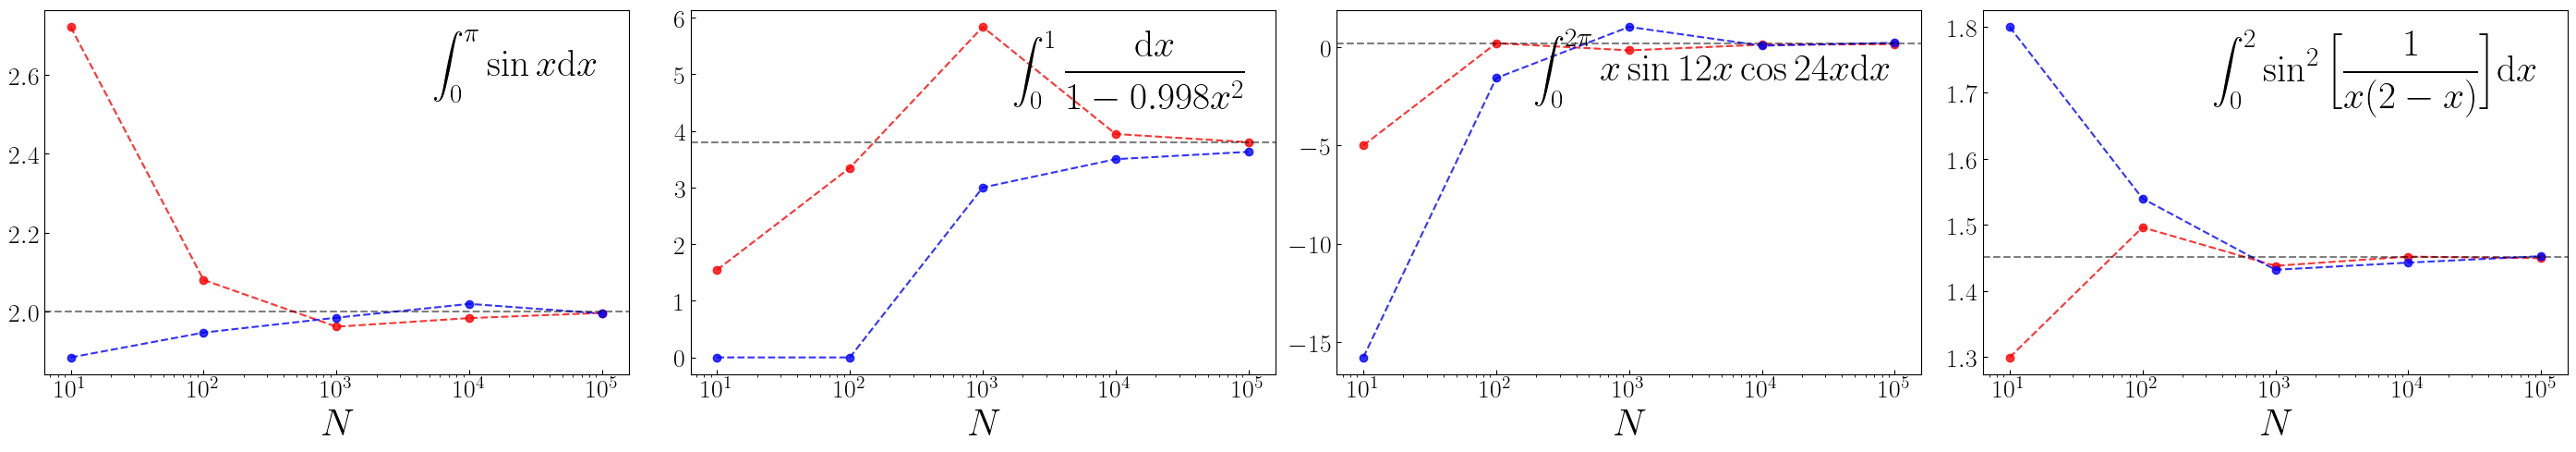

In [18]:
nrows,ncols=1,4
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

expr = [
    r'$\displaystyle \int_{0}^{\pi} \sin{x} {\rm d}{x}$',
    r'$\displaystyle \int_{0}^{1} \frac{{\rm d}{x}}{1-0.998 x^2}$',
    r'$\displaystyle \int_{0}^{2 \pi} x \sin{12 x} \cos{24 x} {\rm d}{x}$',
    r'$\displaystyle \int_{0}^{2} \sin^2\Big[ \frac{1}{x(2-x)} \Big] {\rm d}{x}$'
]
for i in range(4):
    temp = results['mean'][i]
    ax[i].plot(N,temp,marker='o',ls='--',alpha=0.8,color='r')
    
    temp = results['rejection'][i]
    ax[i].plot(N,temp,marker='o',ls='--',alpha=0.8,color='b')
    
    ax[i].axhline(y=results['exact'][i],color='k',ls='--',alpha=0.5)
    
    ax[i].tick_params(axis='both',which='major',direction='in',labelsize=20)
    ax[i].set_xlabel(r'$N$',size=30)
    ax[i].semilogx()
    
    ax[i].text(s=expr[i],x=0.95,y=0.95,va='top',ha='right',transform=ax[i].transAxes,size=30)
    
plt.tight_layout()
plt.show()
# fig.savefig(r'prob3.pdf',bbox_inches='tight')

# Problem 4

In [26]:
# 4.1
N = int(1e6)
x = np.random.uniform(size=N)
y = 2*np.random.uniform(size=N)
res = 2*1*np.mean(np.sin(x**2+y**2))
print(res)

# 4.2
N = int(1e6)
r  = np.random.uniform(size=N)
th = 2*np.pi*np.random.uniform(size=N)
x,y = np.sqrt(r)*np.cos(th),np.sqrt(r)*np.sin(th)
res = np.pi*1**2*np.mean(np.exp(-(x**2+y**2)))
print(res)

# 4.3
N = int(1e6)
x = np.random.uniform(size=N)
y = np.random.uniform(size=N)
cond = y < 1-x
res = 1*1*np.mean((x+y)*cond)
print(res)

# 4.4
N  = int(1e6)
x1 = np.random.uniform(size=N)
x2 = np.random.uniform(size=N)
x3 = np.random.uniform(size=N)
x4 = np.random.uniform(size=N)
res = 1*1*1*1*np.mean(np.exp(-(x1**2 + x2**2 + x3**2 + x4**2)))
print(res)

# 4.5
N  = int(1e6)
x1 = np.random.uniform(size=N)
x2 = np.random.uniform(size=N)
x3 = np.random.uniform(size=N)
x4 = np.random.uniform(size=N)
cond = (x1**2 + x2**2 + x3**2 + x4**2) < 1
res = 2*2*2*2*np.mean(cond*(x1**2 + x2**2 + x3**2 + x4**2)*np.exp(-(x1**2 + x2**2 + x3**2 + x4**2)))
print(res)

0.8708448520110581
1.9859168518247192
0.3332716488769577
0.31118067505327107
1.5853304822003582
